**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

## CIFAR 10

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path

In [ ]:
from fastai.conv_learner import *
PATH = Path("data/cifar10/")

In [ ]:
bs=64
sz=32

In [ ]:
tfms = tfms_from_model(resnet18, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train.csv', tfms=tfms, bs=bs)

In [ ]:
learn = ConvLearner.pretrained(resnet18, data)

In [ ]:
lr=1e-2; wd=1e-5

In [ ]:
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

In [ ]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.249359   1.116181   0.604056  
    1      1.215158   1.07421    0.613115                                                                              


[1.0742103, 0.6131150265957447]

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

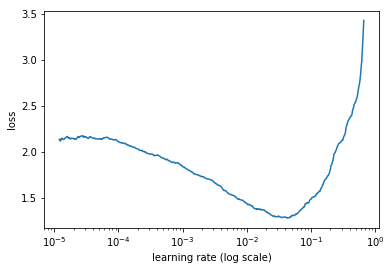

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [ ]:
learn.fit(lrs, 1, cycle_len=1, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.863994   0.792711   0.726479  


[0.7927107, 0.7264793882978723]

## Simplenet

In [ ]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [ ]:
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train.csv', tfms=tfms, bs=bs)

In [ ]:
class SimpleConv(nn.Module):
    def __init__(self, ic, oc, ks=3, drop=0.2, bn=True):
        super().__init__()
        self.conv = nn.Conv2d(ic, oc, ks, padding=(ks-1)//2)
        self.bn = nn.BatchNorm2d(oc, momentum=0.05) if bn else None
        self.drop = nn.Dropout(drop, inplace=True)
        self.act = nn.ReLU(True)
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn: x = self.bn(x)
        return self.drop(self.act(x))

In [ ]:
net = nn.Sequential(
    SimpleConv(3, 64),
    SimpleConv(64, 128),
    SimpleConv(128, 128),
    SimpleConv(128, 128),
    nn.MaxPool2d(2),
    SimpleConv(128, 128),
    SimpleConv(128, 128),
    SimpleConv(128, 256),
    nn.MaxPool2d(2),
    SimpleConv(256, 256),
    SimpleConv(256, 256),
    nn.MaxPool2d(2),
    SimpleConv(256, 512),
    SimpleConv(512, 2048, ks=1, bn=False),
    SimpleConv(2048, 256, ks=1, bn=False),
    nn.MaxPool2d(2),
    SimpleConv(256, 256, bn=False, drop=0),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(256, 10)
)

In [ ]:
bm = BasicModel(net.cuda(), name='simplenet')
learn = ConvLearner(data, bm)
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.unfreeze()
learn.metrics=[accuracy]
lr = 1e-3
wd = 5e-3

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

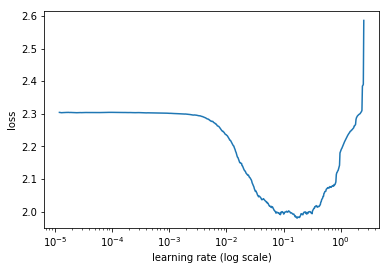

In [ ]:
#sgd mom
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

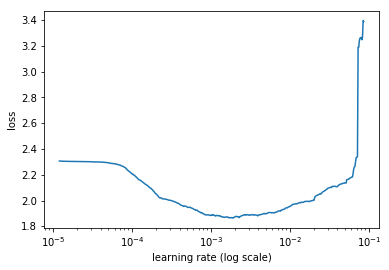

In [ ]:
#adam
learn.lr_find()
learn.sched.plot()

In [ ]:
learn.fit(lr, 1, wds=wd, cycle_len=20, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.464019   1.812134   0.324219  
    1      1.299797   1.872144   0.301779                                                                              
    2      1.152769   1.641428   0.405336                                                                              
    3      1.06013    1.531731   0.46875                                                                               
    4      1.001071   1.344982   0.546875                                                                              
    5      0.957563   1.159598   0.629405                                                                              
    6      0.895986   1.152674   0.619265                                                                              
    7      0.852257   1.277312   0.607713                                                                           

[0.630276, 0.8165724734042553]

In [ ]:
learn.fit(lr, 1, wds=wd, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.603266   2.02473    0.271941  
    1      1.326654   1.682021   0.391955                                                                              
    2      1.124686   1.564738   0.427776                                                                              
    3      0.963391   1.164936   0.603225                                                                              
    4      0.82219    1.19409    0.578291                                                                              


[1.1940901, 0.5782912234042553]

In [ ]:
learn.save('0')

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.819311   1.080679   0.636386  
    1      0.90712    1.294629   0.547457                                                                              
    2      0.717722   0.938504   0.700881                                                                              
    3      0.898441   1.263396   0.586187                                                                              
    4      0.803364   1.037912   0.666888                                                                              
    5      0.668088   0.855235   0.737616                                                                              
    6      0.616654   0.754756   0.770778                                                                              


[0.75475585, 0.7707779255319149]

In [ ]:
learn.save('1')

In [ ]:
learn.fit(lr, 1, wds=wd, cycle_len=10, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.833685   1.148864   0.620928  
    1      0.819332   1.212562   0.608627                                                                              
    2      0.803363   0.984564   0.697224                                                                              
    3      0.790965   1.016013   0.702045                                                                              
    4      0.733683   0.902306   0.735622                                                                              
    5      0.698549   0.878661   0.732131                                                                              
    6      0.648197   0.783731   0.758311                                                                              
    7      0.597658   0.738099   0.782912                                                                           

[0.60334516, 0.8220578457446809]

In [ ]:
learn.save('2')

## Fin